# Proyecto 1 - Time Series Analysis:


Andres Felipe Díaz Méndez - 201924178

Arvid Tenganá Hurtado - 201527819

Juan David Barreto Pérez- 202020148

Juan Felipe Martínez Ramos - 201113765

Luis Miguel Torres Aponte - 202022939

### 1. Choosing your time series (Friday July 11th).

For the project, each group must select a dataset of their choice where the analysis can be performed using a time series model. There are many sources of time series data on the Internet. Government agencies are some of the best sources. But be resourceful. It is better to find a data set is from a process that interests you. Use a recent time-series, also try to avoid a tipical stock-price / exchange rates series. The selected time series must be sent no later than Sunday, July 11, 11:59 pm, through Sicua +, for approval.

The analysis of the data must consider:

### 2. Analysis of the context of the problem and relevance of the analysis: This should answer the question of why it is interesting or important to study the selected data.

Kailo es una tienda online para mascotas, en la que se encuentra toda una variedad de líneas de productos y servicios a domicilio en Colombia. Se cuentan con más de 4.000 productos (alimentos, dietas naturales, snacks, medicinas, higiene y accesorios) y otros servicios (medicina, veterinaria, etc.). En la empresa se encuentran productos de todas las gamas llegando a un mercado sumamente amplio para pet lovers. 

La tienda online comenzó a funcionar en septiembre de 2020, teniendo un incremento constante en sus ventas, es por ello por lo que resulta necesario un análisis del comportamiento de estos montos para tener una idea de cómo van a ser sus ventas en un futuro, así como evaluar algunos patrones estacionales que les permitan observar en que días suben las ventas. La compañía sabe que el 90 % de sus ventas se encuentra en la ciudad de Bogotá y su negocio más grande y con mayor crecimiento son las líneas de producto de alimentos para mascotas, por ello cuenta con una serie de tiempo diaria con las ventas de productos alimenticios. La tienda no procesa encargos los domingos ni días festivos, para el resto de los días se sumarizan el total de las ventas que se realizan a diario. 


### Pre-Procesamiento de los datos:

In [50]:
import pandas as pd
import holidays_co
import matplotlib.pyplot as plt
import warnings
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('../datasets/dataset_proyecto1.zip')

- Se creeó un nuevo feature booleano para determinar cuales productos eran alimentos y cuales no dependiendo dee la categoría del producto.

In [6]:
df['ALIMENTOS'] = (df.CAT_SNACKS + df.CAT_ALIMENTO_PRESCRIPCION + df.CAT_ALIMENTO) >= 1
df['ALIMENTOS'] = df.ALIMENTOS.astype('int')
df.head()

,date,warehouse_id_ref,itemid,demand,pending_demand,lastPrice,Price,stock,available_stock,city,...,CAT_HIGIENE,CAT_REGALOS,CAT_PARA_PETLOVERS,CAT_FARMAPET,CAT_PREMIOS,CAT_VETERINARIOS,CAT_ALIMENTO,CAT_COMBOS,CAT_ARENAS,ALIMENTOS
0,2020-08-17T00:00:00.000Z,1,9953,0,0,11560.0,11560.0,3.0,1.0,Bogota,...,0,0,0,1,0,0,0,0,0,0
1,2020-08-18T00:00:00.000Z,1,9953,0,0,11560.0,11560.0,3.0,1.0,Bogota,...,0,0,0,1,0,0,0,0,0,0
2,2020-08-19T00:00:00.000Z,1,9953,2,0,11560.0,11560.0,3.0,1.0,Bogota,...,0,0,0,1,0,0,0,0,0,0
3,2020-08-20T00:00:00.000Z,1,9953,0,0,11560.0,11560.0,3.0,1.0,Bogota,...,0,0,0,1,0,0,0,0,0,0
4,2020-08-21T00:00:00.000Z,1,9953,0,0,11560.0,11560.0,3.0,1.0,Bogota,...,0,0,0,1,0,0,0,0,0,0


In [7]:
df = df[['date', 'warehouse_id_ref', 'itemid', 'demand', 'pending_demand', 
         'lastPrice', 'Price', 'stock', 'available_stock', 'city', 'ALIMENTOS']]

- Con el nuevo feature obtuvimos dos datasets al filtrar por productos alimenticios y productos no alimenticios.

In [20]:
df_alimentos = df[(df.ALIMENTOS == 1) & (df.city == "Bogota")]
df_no_alimentos = df[(df.ALIMENTOS == 0) & (df.city == "Bogota")]

- Tomamos los datos despues de el Septiembre del 2020 debido a que los datos anteriores eran en su mayoria cero.

In [21]:
df_alimentos = df_alimentos[df_alimentos['date'] >= '2020-09-01']
df_no_alimentos = df_no_alimentos[df_no_alimentos['date'] >= '2020-09-01']

- Así obtuvimos la serie de tiempo de ventas netas para productos alimenticios y productos no alimenticios.

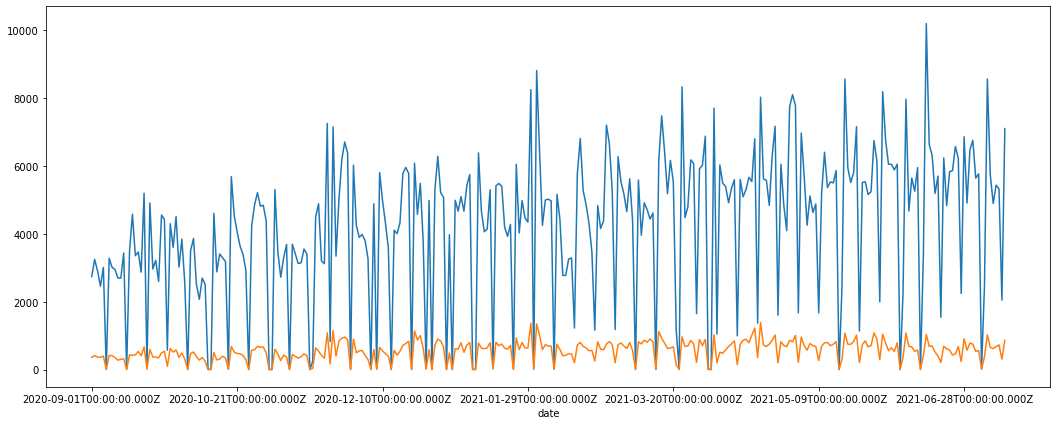

In [22]:
# Obtener la serie de tiempo de ventas para productos alimenticios.
df_alimentos.groupby('date')['demand'].sum().plot(figsize=(18,7))

# Obtener la serie de tiempo de ventas para productos no alimenticios.
df_no_alimentos.groupby('date')['demand'].sum().plot(figsize=(18,7))

- Se decició trabajar con la serie de productos alimenticios debido a que las ventas eran mayores, asi mismo como se observa en la gráfica anterior fué necesario eliminar los datos de los domingos ya que son siempre cero y alterarias las predicciónes.

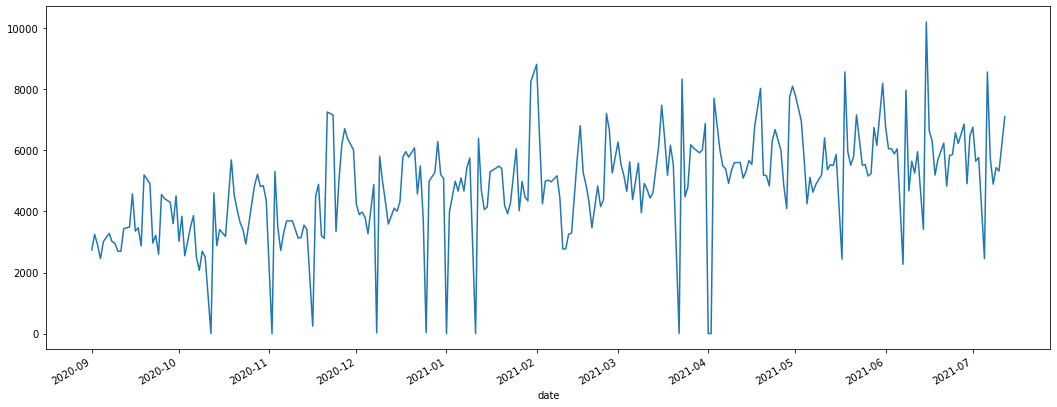

In [17]:
df_alimentos.date = pd.to_datetime(df_alimentos.date)
df_alimentos_sin_fds = df_alimentos[ ~df_alimentos.date.dt.weekday.isin([6]) ]
df_alimentos_sin_fds.groupby('date')['demand'].sum().plot(figsize=(18,7))

- Posteriormente también fue necesario eliminar los datos correspondientes a los días festivos ya que en estos tampoco se realizan ventas, la Serie de tiempo obtenida después de eliminar estos datos se puede observar en la siguiente gráfica:

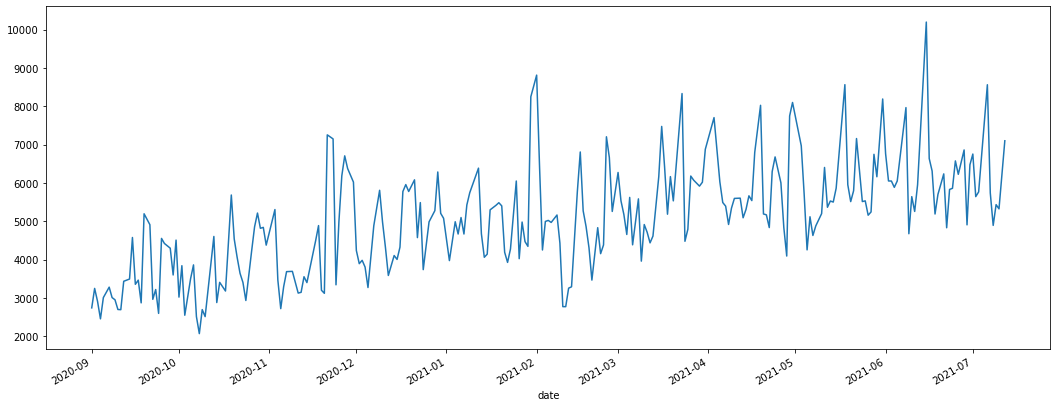

In [31]:
festivos = [ x[0] for x in (holidays_co.get_colombia_holidays_by_year(2020) + holidays_co.get_colombia_holidays_by_year(2021)) ]

df_alimentos_sin_fds_ni_festivos = df_alimentos_sin_fds[ ~df_alimentos_sin_fds.date.isin( festivos ) ]
df_alimentos_sin_fds_ni_festivos.groupby('date')['demand'].sum().plot(figsize=(18,7))

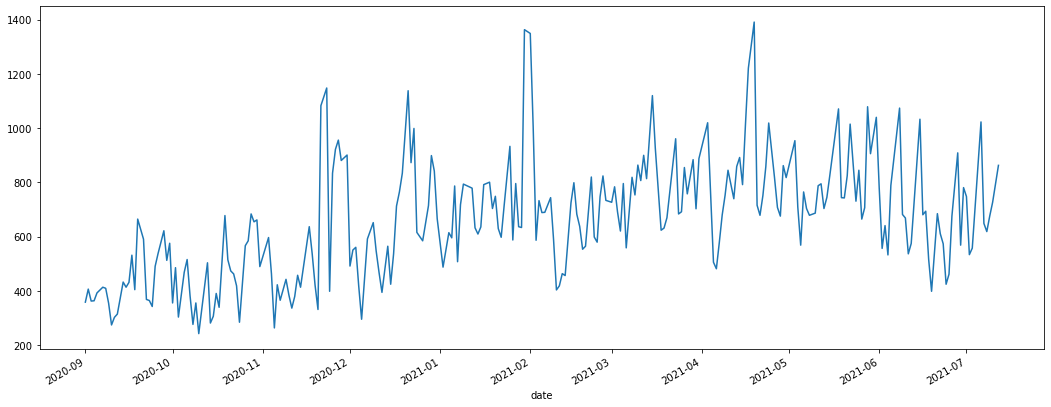

In [32]:
# Se realizó el mismo procedimiento para la serie de productos no alimenticios
df_no_alimentos.date = pd.to_datetime(df_no_alimentos.date)
df_no_alimentos_sin_fds = df_no_alimentos[ ~df_no_alimentos.date.dt.weekday.isin([6]) ]
df_no_alimentos_sin_fds_ni_festivos = df_no_alimentos_sin_fds[ ~df_no_alimentos_sin_fds.date.isin( festivos ) ]
df_no_alimentos_sin_fds_ni_festivos.groupby('date')['demand'].sum().plot(figsize=(18,7))

### 3. Understanding the data: Understand and analyze the main components of the time series, for example: seasonality, cyclicity, autocorrelation, behavior of the residuals, among others. Make use of graphs that allow you to understand each of the components clearly.

- Lo primero que se realizó fue el test de Dickey Fuller, segun el cual con un P-valor de 0.6% se determina que la serie es estacionaria.

In [18]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [19]:
adf_test(df_alimentos_sin_fds_ni_festivos.groupby('date')['demand'].sum())

Results of Dickey-Fuller Test:
Test Statistic                  -3.558286
p-value                          0.006610
#Lags Used                       4.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


- Asi mismo se usó una media móvil de 15 días para obtener la tendencia de la serie de tiempo de ventas para productos alimenticios.

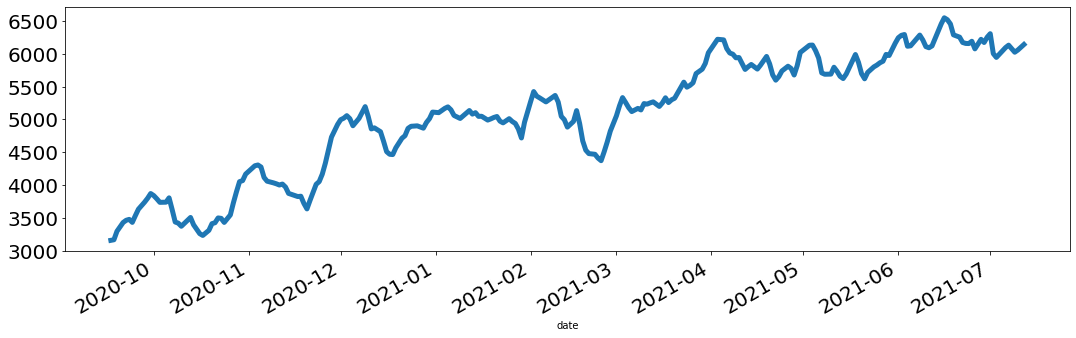

In [34]:
df_alimentos_sin_fds_ni_festivos.groupby('date')['demand'].sum().rolling(15).mean().plot(figsize=(18,5), linewidth=5, fontsize=20)


- De la misma forma se realizó una diferenciación a serie de tiempo para obtener la estacionalidad de la serie de tiempo. 

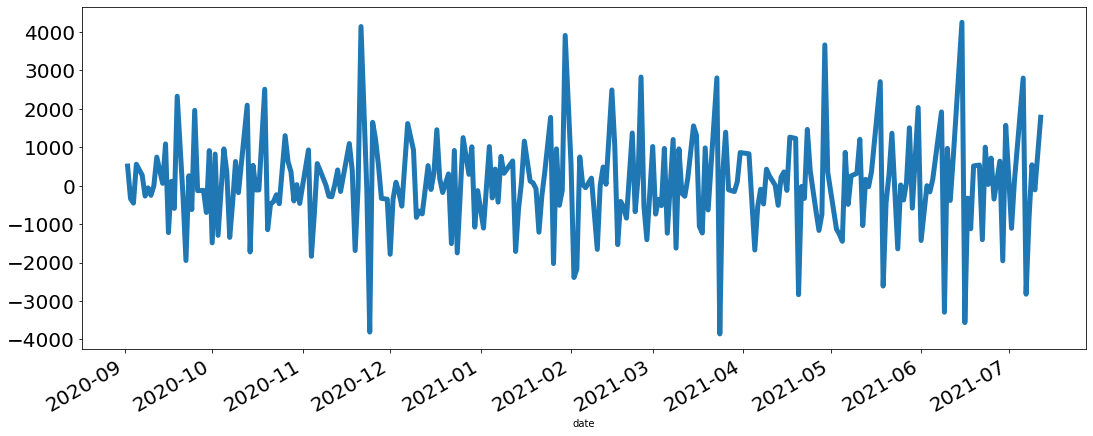

In [35]:
df_alimentos_sin_fds_ni_festivos.groupby('date')['demand'].sum().diff().plot(figsize=(18,7), linewidth=5, fontsize=20)

- También obtuvimos los gráficos de  de autocorrelación y autocorrelación parcial, los cuales indican que al parecer se trata de un proceso Auto regresivo de lag 1.

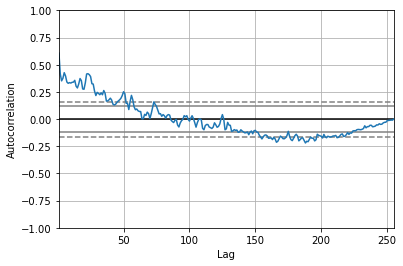

In [37]:
pd.plotting.autocorrelation_plot(df_alimentos_sin_fds_ni_festivos.groupby('date')['demand'].sum())

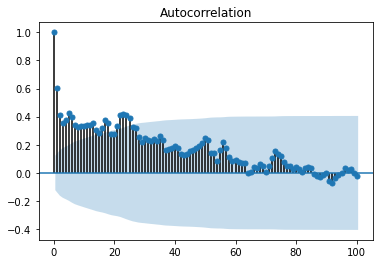

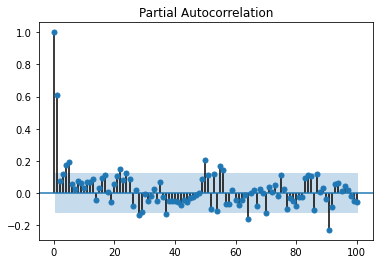

In [39]:
plot_acf( df_alimentos_sin_fds_ni_festivos.groupby('date')['demand'].sum(), lags=100);
plot_pacf( df_alimentos_sin_fds_ni_festivos.groupby('date')['demand'].sum(), lags=100);

### 4. Application of the models in predictions: Correct use of the models seen in class to make predictions related to the problem of interest.

- El primer modelo que se realizó fué un modelo ARIMA con parámetros (1,1,1), los resultados obtenidos fueron:

In [45]:
from statsmodels.tsa.arima_model import ARIMA

series = df_alimentos_sin_fds_ni_festivos.groupby('date')[['demand']].sum()

# fit model
model = ARIMA(series, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.demand   No. Observations:                  254
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2118.570
Method:                       css-mle   S.D. of innovations           1004.663
Date:                Sun, 18 Jul 2021   AIC                           4245.140
Time:                        22:27:44   BIC                           4259.289
Sample:                             1   HQIC                          4250.832
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             12.2423      1.306      9.376      0.000       9.683      14.801
ar.L1.D.demand     0.3495      0.059      5.916      0.000       0.234       0.465
ma.L1.D.demand    -1.0000      0.014

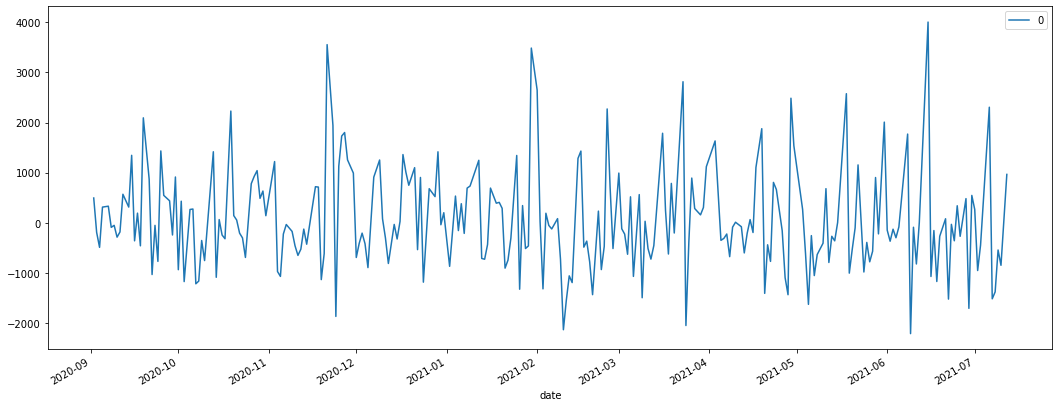

In [47]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize=(18,7))
plt.show()

- Posteriormente se realizó una búsqueda exhaustiva de parámetros minimizando el MAE para un modelo ARIMA:

In [33]:
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

#Iterando
results = []
for p in range(1,9):        
    for d in range(0,4):                
        for q in range(1,6):
            
            try:                
                # Create and fit ARMA(p,q) model
                X = series
                size = int(len(X) * 0.8)
                train, test = X[0:size], X[size:len(X)]

                model = ARIMA(train, order=(p,d,q))
                model_fit = model.fit(disp=0)
                output= model_fit.forecast(steps=len(test))[0]
                yhat = output
                predictions = yhat
                real_values = test
                error = mean_absolute_error(test, predictions)

                # Print p, q, AIC, BIC
                #print(p, d, q, 'Test MAE: %.3f' % error) 
                results.append([p,d,q,error])
                
            except Exception as e:
                #print(p, d, q, None )
                results.append([p,d,q,None])
                
df = pd.DataFrame(results,columns=['p','d','q','mae'])

In [34]:
df.loc[df['mae'] == df['mae'].min()]

,p,d,q,mae
41,3,0,2,706.135209


- Los parámetros obtenidos fuero (3,0,2) y el modelo ARIMA entrenado fué el siguiente:

In [48]:
series.index = pd.to_datetime(series.index.date)
X = series
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

model = ARIMA(train, order=(3,0,2))
model_fit = model.fit(disp=0)

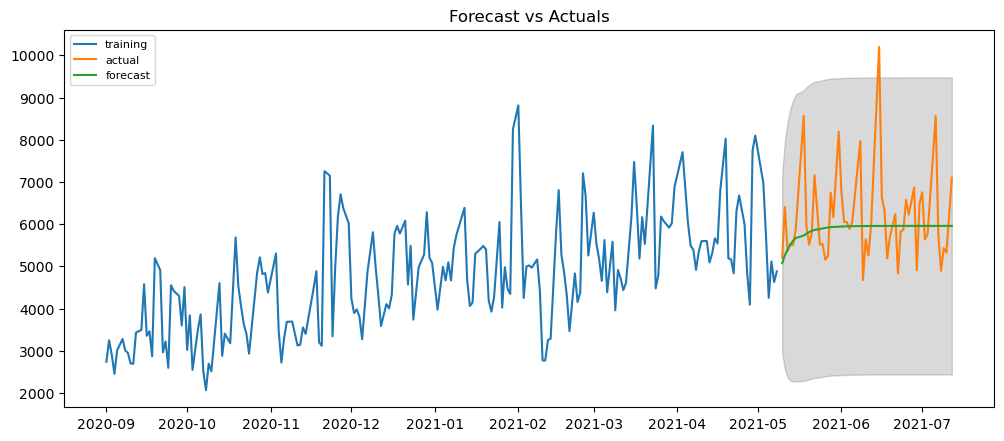

In [49]:
# Forecast
fc, se, conf = model_fit.forecast(51)

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [51]:
mean_absolute_error(test, fc)

705.8679546509856

- Finalmente Relizamos otro modelo ARIMA con una librería que escoge los parámetros.

In [35]:
from pmdarima.arima import auto_arima

In [36]:
model = auto_arima(train, X=None, start_p=1, d=None, start_q=1, max_p=9, max_d=1, max_q=9)
model_fit = model.fit(train)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  204
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1688.876
Date:                Sun, 18 Jul 2021   AIC                           3385.751
Time:                        21:36:19   BIC                           3399.004
Sample:                             0   HQIC                          3391.113
                                - 204                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4727      0.074      6.400      0.000       0.328       0.617
ar.L2         -0.1554      0.077     -2.016      0.044      -0.307      -0.004
ma.L1         -0.9283      0.040    -23.446      0.000      -1.006      -0.851
sigma2      9.753e+05   7.72e+04     12.635      0.000    8.24e+05    1.13e+06
===================================================================================
Ljung-Box (Q):                       32.73   Jarque-Bera (JB):                25.59
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.64
Prob(H) (two-sided):                  0.39   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

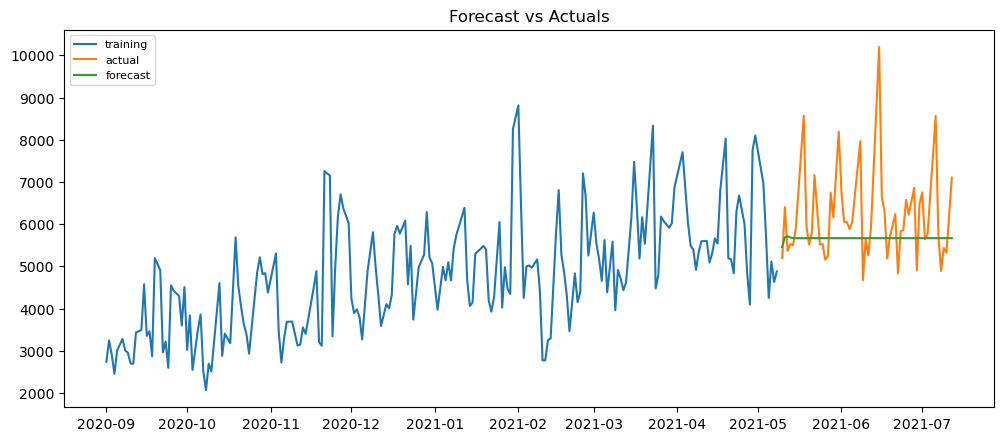

In [37]:
# Forecast
fc = model_fit.predict(51)

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
#lower_series = pd.Series(conf[:, 0], index=test.index)
#upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [38]:
mean_absolute_error(test, fc)

748.9924885754529

- La búsqueda exhaustiva de parámetros y la librería de auto modelamiento obtuvieron un MAE muy similar. De alrededor de 700.

- Finalmente se realizó un modelo con Prophet.

In [39]:
from prophet.plot import add_changepoints_to_plot
from prophet import Prophet
import pandas as pd
import numpy as np
%matplotlib inline

In [40]:
series = df_alimentos_sin_fds_ni_festivos.groupby('date')['demand'].sum()
df_prophet = pd.DataFrame( series ).reset_index().rename(columns={'date':'ds','demand':'y'})
df_prophet.ds = df_prophet.ds.dt.date

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


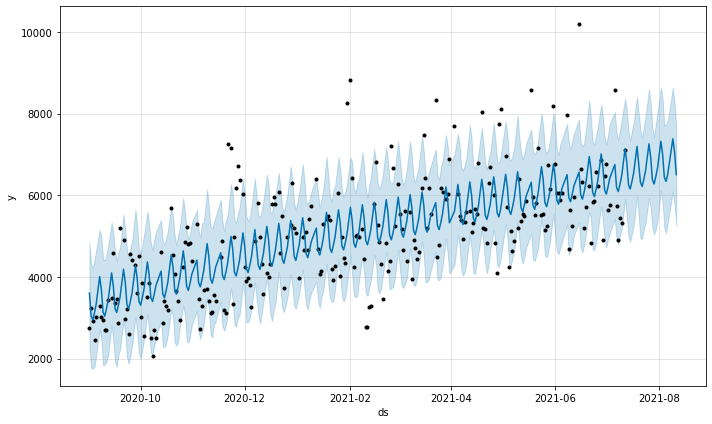

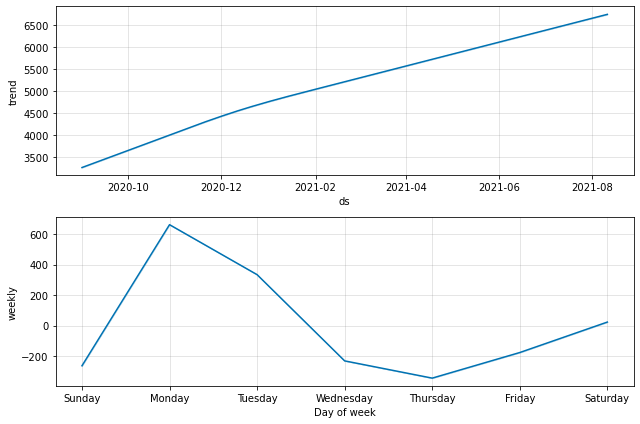

In [41]:
m = Prophet()
m.fit(df_prophet)

future = m.make_future_dataframe(periods=30, freq='D')
future = future[ ~future.ds.dt.weekday.isin([6]) ]
future = future[ ~future.ds.isin( festivos ) ]

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


fig1 = m.plot(forecast)
m.plot_components(forecast);

- Algo a recalcar es que Prophet es capaz de capturar la estacionalidad semanal de las ventas y cómo se puede observar en los gráficos resultantes el pico de ventas en su mayoría se presenta los días lúnes y el valle mas profundo los días jueves.

- Posteriormente se realizó cross-validation para obtener valores de MAE para diferentes datasets de train y test para el modelo dee prophet.

In [42]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
df_cv = cross_validation(m, initial='60 days', period='15 days', horizon = '50 days')

INFO:prophet:Making 14 forecasts with cutoffs between 2020-11-09 00:00:00 and 2021-05-23 00:00:00


In [43]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,5 days,1.395302e+06,1181.229053,974.172500,0.213390,0.163283,0.194099,0.655844
1,6 days,1.469142e+06,1212.081835,972.522879,0.214632,0.166616,0.193496,0.696429
2,7 days,1.570791e+06,1253.311992,996.154407,0.208221,0.156622,0.191205,0.694805
3,8 days,1.274324e+06,1128.859748,883.336892,0.177163,0.134223,0.165656,0.732143
4,9 days,1.242180e+06,1114.531290,842.767170,0.160350,0.131754,0.153830,0.738095
5,10 days,1.193256e+06,1092.362421,804.481821,0.140727,0.121700,0.141177,0.758929
6,11 days,1.077737e+06,1038.141261,765.502912,0.132373,0.121700,0.134460,0.726190
7,12 days,9.980049e+05,999.001950,732.251273,0.131985,0.117619,0.131932,0.761364
8,13 days,1.004261e+06,1002.128431,734.525101,0.140774,0.112301,0.135612,0.791071
9,14 days,1.083881e+06,1041.095844,779.303510,0.150235,0.109133,0.144032,0.791667


In [44]:
df_p["mae"].mean()

905.7052220270808

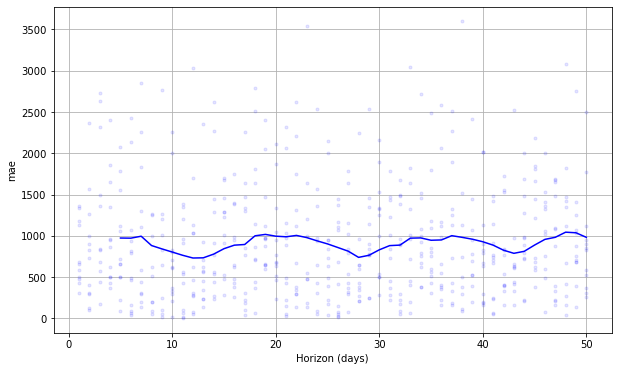

In [45]:
fig = plot_cross_validation_metric(df_cv, metric='mae')

- Finalmente el ultimo modelo que se realizó también fue un modelo de Prophet en el cual se dejaron los festivos en el dataset pero asi mismo se creó un dataframe con los festivos de Colombia y debido a que Prophet soporta días festivos en su forecast se obtuvo un modelo que tiene en cuenta los días festivo.

In [46]:
festivos_col = [ (x[0],x[1]) for x in (holidays_co.get_colombia_holidays_by_year(2020) + holidays_co.get_colombia_holidays_by_year(2021)) ]
df_festivos_col = pd.DataFrame( festivos_col, columns=['ds','holiday'])

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


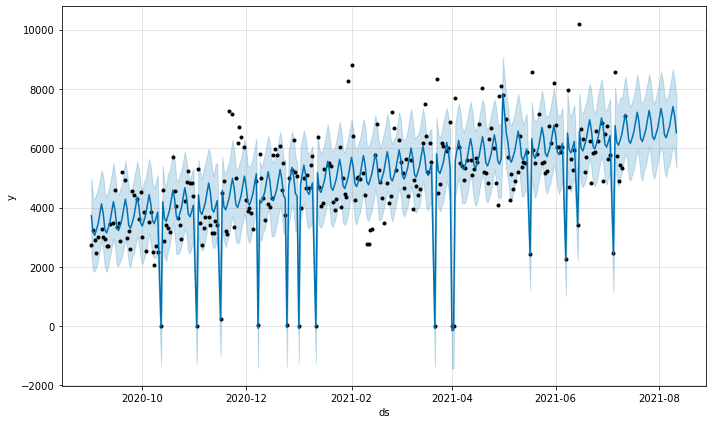

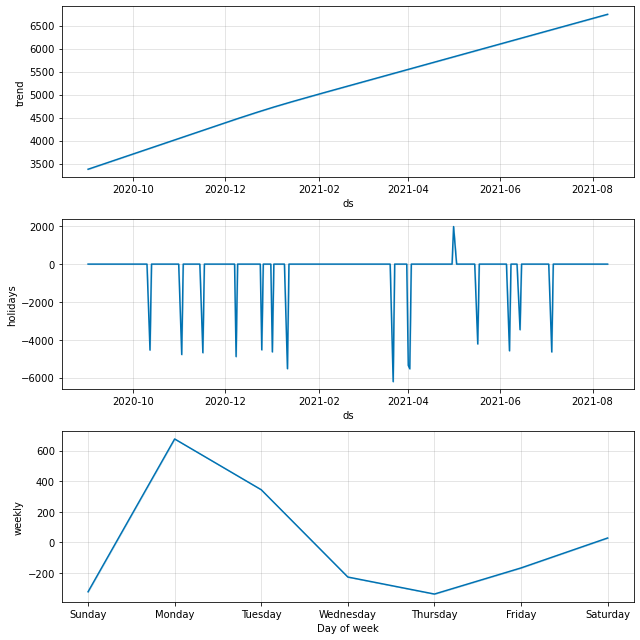

In [47]:
series = df_alimentos_sin_fds.groupby('date')['demand'].sum()

df_prophet = pd.DataFrame( series ).reset_index().rename(columns={'date':'ds','demand':'y'})
df_prophet.ds = df_prophet.ds.dt.date

m = Prophet(holidays = df_festivos_col)
m.fit(df_prophet)

future = m.make_future_dataframe(periods=30, freq='D')
future = future[~future.ds.dt.weekday.isin([6])]

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


fig1 = m.plot(forecast)
m.plot_components(forecast);

In [48]:
df_cv = cross_validation(m, initial='60 days', period='15 days', horizon = '50 days')

INFO:prophet:Making 14 forecasts with cutoffs between 2020-11-09 00:00:00 and 2021-05-23 00:00:00


In [49]:
df_p = performance_metrics(df_cv)
df_p

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,5 days,2.301092e+06,1516.935069,1109.654717,0.161758,0.251369,0.633333
1,6 days,2.008391e+06,1417.177153,1043.974058,0.161758,0.221294,0.683333
2,7 days,2.473950e+06,1572.879418,1145.589506,0.161758,0.250300,0.666667
3,8 days,2.483064e+06,1575.774008,1103.337457,0.145756,0.255776,0.683333
4,9 days,3.239497e+06,1799.860295,1199.397374,0.135758,0.287697,0.666667
5,10 days,3.204268e+06,1790.046897,1168.670028,0.131754,0.276656,0.683333
6,11 days,3.098315e+06,1760.203164,1138.072170,0.126915,0.271693,0.650000
7,12 days,2.691211e+06,1640.490981,1040.757299,0.120122,0.241565,0.700000
8,13 days,2.433107e+06,1559.842102,974.454302,0.115758,0.212589,0.750000
9,14 days,2.081409e+06,1442.708805,944.040823,0.115758,0.206595,0.750000


In [50]:
df_p["mae"].mean()

1141.0234595809823

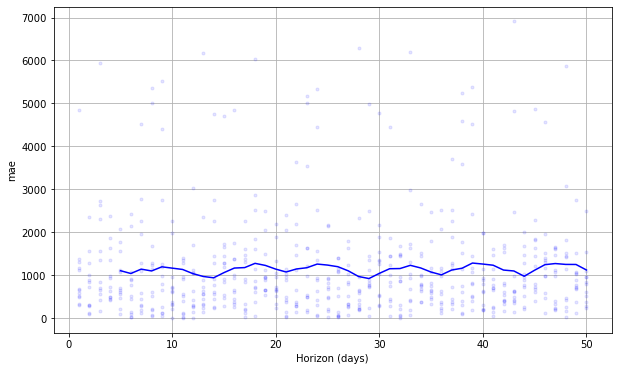

In [51]:
fig = plot_cross_validation_metric(df_cv, metric='mae')

### 5. Conclusions: The conclusions must be relevant to the problem of interest. Conclusions on the procedures performed are also expected.

- La serie de tiempo tiene un comportamiento estacionario de acuerdo a la prueba de Dickey Fuller, al entregar un p-valor de 0.01 rechazando la hipótesis nula de que la serie tiene raíz unitaria. Cabe destacar que visualmente se podría llegar a plantear lo contrario dado que se ve lo que parece un comportamiento creciente en el tiempo 

- En el modelo ARIMA, los parámetros que minimizan el MSE son: un lag de p=3, 2 diferenciaciones d=2, y una ventana de tiempo del promedio móvil de q=1, resultando en una predicción con forma de línea recta, lo cual muestra que el modelo no logra capturar el comportamiento no lineal de la serie, y que puede deberse a que hay mucha variabilidad en la serie. 

- La serie de tiempo presenta una acumulación mayor en cantidad de alimentos los días lunes, luego van disminuyendo estas cantidades durante el transcurso de los días y desde el viernes hasta el domingo presenta una leve recuperación. Teniendo en cuenta lo anterior, se debe considerar que las cantidades más altas se presentan al inicio de la semana, siendo estas lunes y martes, donde se debe poner mayor atención en los pronósticos. 

- En el modelo Prophet, se puede ver que el error no aumenta a medida que se predice más tiempo en el horizonte 

- El modelo de Prophet en su mayoría logra capturar el comportamiento de los datos de test, ya que como se observa en las gráficas la gran mayoría de datos se encuentran dentro del intervalo de confianza que establece el modelo de Prophet. Sin embargo, no logra capturar ni predecir los picos de demanda de productos debido a que estos deben obedecer un comportamiento más complejo que no es propio de la serie de tiempo como  promociones o mayor publicidad. 